In [1]:
import requests as r
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import time
import datetime as dt
import seaborn as sns
# %matplotlib notebook
%matplotlib inline

In [2]:
urlCTs = 'https://api.covid19api.com/countries'

countries = None
while True:
    countries = r.get(urlCTs)
    if(countries.status_code == 200): 
      break
    time.sleep(1.0)

lstCts = countries.json()
dfCountries = pd.DataFrame.from_records(lstCts)
dfCountries.set_index('Country',inplace=True)
# display(dfCountries)
# dfCountries.loc['Brazil'][0]

In [3]:
#input of the user
countryList = []
countries = []
while True: 
  country = input('Type a country name or type 0 to quit: ')
  if country == '0': break
  countries.append(country)
  countryList.append(dfCountries.loc[country][0])

Type a country name or type 0 to quit: Brazil
Type a country name or type 0 to quit: Australia
Type a country name or type 0 to quit: Italy
Type a country name or type 0 to quit: 0


In [4]:
#processing urls of each country
urls = countryList.copy()
for i in range(len(urls)):
  urls[i] = 'https://api.covid19api.com/dayone/country/'+urls[i]
# print(urls)

In [5]:
#retriving data for each country
ans = urls.copy()
for i in range(len(urls)):
  while True:
    ans[i] = r.get(urls[i])
    if(ans[i].status_code == 200): 
      break
    time.sleep(1.0)

In [6]:
#retriving data for each country
raw_datas = []
for item in ans:
   raw_datas.append(item.json())

In [9]:
#Data cleaning
countrycdT = []
countrycdT.append(raw_datas[0][0]['CountryCode'])
dfT = pd.DataFrame.from_records(raw_datas[0],exclude=['City','Province','CityCode','Lat','Lon','ID','Active','Recovered','Country','CountryCode'])
dfT['Date'] = pd.to_datetime(dfT['Date'])
dfT = dfT[['Confirmed','Deaths']].groupby(dfT['Date']).sum().reset_index()
dfT['Lethality%'] = dfT['Deaths']/dfT['Confirmed']*100
dfT.rename(columns={'Lethality%':'Lethality%'+countrycdT[0]},inplace=True)
del(dfT['Deaths'])
del(dfT['Confirmed'])


for item in raw_datas[1:]:
  countrycd = item[0]['CountryCode']
  df = pd.DataFrame.from_records(item,exclude=['City','Province','CityCode','Lat','Lon','ID','Active','Recovered','Country','CountryCode'])
  df['Date'] = pd.to_datetime(df['Date'])
  df = df[['Confirmed','Deaths']].groupby(df['Date']).sum().reset_index()
  df['Lethality%'] = df['Deaths']/df['Confirmed']*100
  df.rename(columns={'Lethality%':'Lethality%'+countrycd},inplace=True)
  del(df['Deaths'])
  del(df['Confirmed'])
  dfT = pd.merge(dfT, df, how='inner', on=['Date'])
  countrycdT.append(countrycd)



In [11]:
dfT.head()

,Date,Lethality%BR,Lethality%AU,Lethality%IT
0,2020-02-26 00:00:00+00:00,0.0,0.000000,2.649007
1,2020-02-27 00:00:00+00:00,0.0,0.000000,2.595420
2,2020-02-28 00:00:00+00:00,0.0,0.000000,2.364865
3,2020-02-29 00:00:00+00:00,0.0,0.000000,2.570922
4,2020-03-01 00:00:00+00:00,0.0,3.703704,2.007084


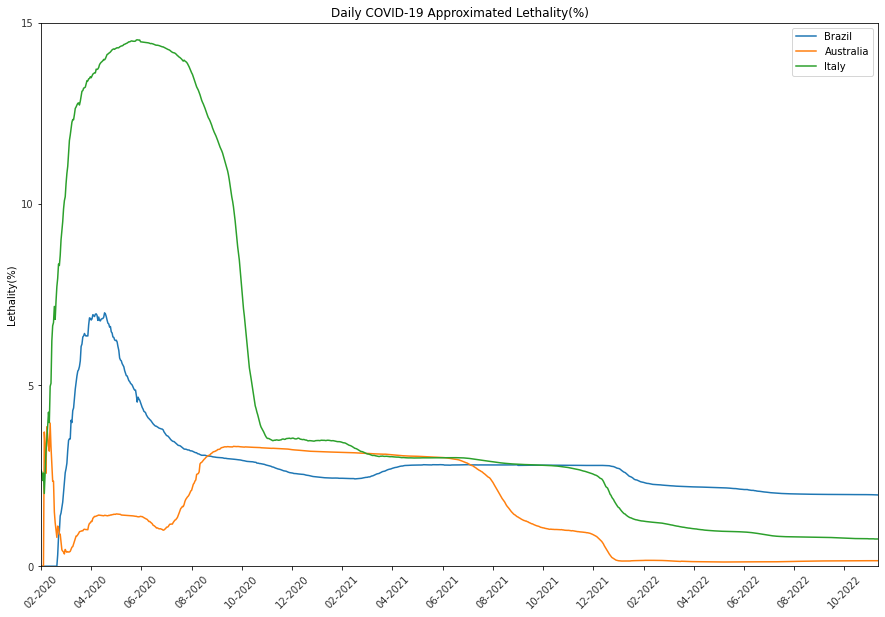

In [12]:
#Visualization
n = len(dfT)
plt.figure(figsize=(15,10))
for i in range(len(countryList)):
  plt.plot(range(n),dfT['Lethality%'+countrycdT[i]].tolist(), label=countries[i])

plt.gca().set_xlim(0,n-1)
# plt.gca().set_xlabel('Months')
plt.gca().set_ylabel('Lethality(%)')
plt.gca().set_title('Daily COVID-19 Approximated Lethality(%)')
plt.gca().set_ylim(0,15)
dfNames = dfT['Date'].iloc[0::60].dt.month.apply(lambda x: str(x) if x//10>=1 else '0'+str(x))+'-'+dfT['Date'].iloc[0::60].dt.year.apply(str)
dfNames = dfNames.reset_index() 

plt.yticks([0,5,10,15],alpha=0.8)
plt.xticks(dfNames['index'],dfNames['Date'],alpha=0.8,rotation=45)
plt.legend()
plt.show()